# Assignment 1 
Due date: 19 April 20223

## Thermodynamic variables and vertical structure of dropsonde data

We use the *JOANNE* dropsonde dataset from the EUREC4A field campaign to plot campaign-mean vertical profiles. The dataset has a number of readily available variables that already have been averaged over the HALO flight circles. These include horizontal winds `u` and `v`, specific humidity `q`, air temperature `ta`, air pressure `p`, as well as the area-averaged mass divergence `D`, vertical velocity `W` and pressure velocity ω (`omega`).

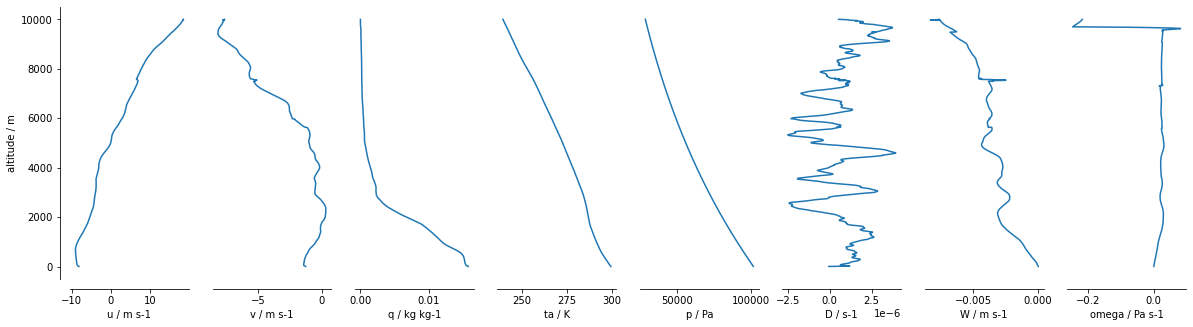

In [1]:
import datetime
import numpy as np
import eurec4a
import matplotlib.pyplot as plt

def joanne_data(variables=None):
    cat = eurec4a.get_intake_catalog()
    d = cat.dropsondes.JOANNE.level4.to_dask().mean(dim=['circle'], keep_attrs=True)
    if variables: return d.drop_vars([item for item in list(d) if item not in variables])
    else        : return d

def adjust_spines(ax, spines):
    # https://matplotlib.org/3.4.3/gallery/ticks_and_spines/spine_placement_demo.html
    for loc, spine in ax.spines.items():
        if loc in spines: spine.set_position(('outward', 10))  # outward by 10 points
        else:             spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines: ax.yaxis.set_ticks_position('left')
    else: ax.yaxis.set_ticks([]) # no yaxis ticks
    if 'bottom' in spines: ax.xaxis.set_ticks_position('bottom')
    else: ax.xaxis.set_ticks([]) # no xaxis ticks
        
def fig_vertical_profiles(plot_vars):
    fig, axs = plt.subplots(1, len(plot_vars), figsize=(20,5))
    for i,v in enumerate(plot_vars):
        ax = axs[i]
        d = joanne_data([v])[v]
        ax.plot(d.values, d.alt.values)
        if i == 0 : 
            adjust_spines(ax,['left', 'bottom'])
            ax.set_ylabel('altitude / m')
        else      : adjust_spines(ax,['bottom'])
        ax.set_xlabel(f'{d.name} / {d.units}')
    return fig, axs

plot_vars = ['u','v','q','ta','p','D','W','omega']
fig, axs = fig_vertical_profiles(plot_vars)
fig.show()

Based on the available data we can calculate the potential temperature $\theta$, the temperature an air parcel would have if it was brought to reference pressure. The potential temperature assumes dry air and usually surface pressure (often idealised as 1000 hPa) is used as the reference state. The virtual potential temperature $\theta_v$ like the potential temperature $\theta$ assumes dry air, but adjusts the pressure density of the parcel to be equal to that of the moist parcel. The equivalent potential temperature $\theta_e$ includes the effect of latent heat. $\theta_e$ is the temperature a parcel would have if all its moisture was condensed and it was brought to the reference level. saturation equivalent potential temperature $\theta_{e,s}$ is the equivalent potential temperature a parcel would have, would it be saturated.

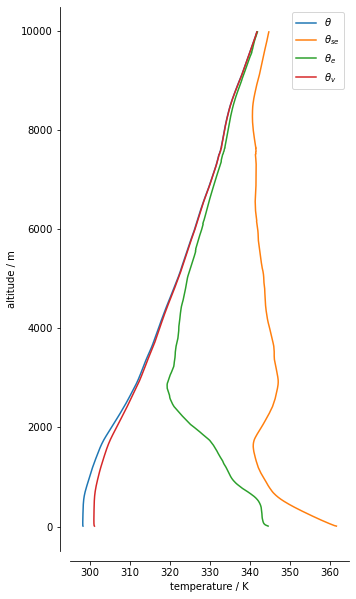

In [2]:
import metpy.calc  as mpcalc
from metpy.units import units as mpunit
import metpy.constants as mpconst

def theta(d):
    R  = mpconst.Rd.magnitude
    Cp = mpconst.Cp_d.magnitude
    temperature = d['ta']
    pressure    = d['p']
    p0 = np.nanmax(d['p'].values) 
    p0 = 100000
    return temperature * (p0 / pressure)**(R/Cp)

def add_potential_temperatures(d):
    temperature = d['ta'] * mpunit.K
    pressure    = d['p']  * mpunit.Pa
    specific_humidity  = d['q']
    dewpoint      = mpcalc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
    mixing_ratio  = mpcalc.mixing_ratio_from_specific_humidity(specific_humidity)
    d['theta']    = mpcalc.potential_temperature(pressure, temperature).metpy.dequantify()
    d['theta_se'] = mpcalc.saturation_equivalent_potential_temperature(pressure, temperature).metpy.dequantify()
    d['theta_e']  = mpcalc.equivalent_potential_temperature(pressure, temperature, dewpoint).metpy.dequantify()
    d['theta_v']  = mpcalc.virtual_potential_temperature(pressure, temperature, mixing_ratio).metpy.dequantify()
    d['theta']    = d['theta'   ].assign_attrs(standard_name='potential_temperature',                      label='$\\theta$')
    d['theta_v']  = d['theta_v' ].assign_attrs(standard_name='virtual_potential_temperature',              label='$\\theta_v$')
    d['theta_e']  = d['theta_e' ].assign_attrs(standard_name='equivalent_potential_temperature',           label='$\\theta_e$')
    d['theta_se'] = d['theta_se'].assign_attrs(standard_name='saturated_equivalent_potential_temperature', label='$\\theta_{se}$')
    return d

def fig_multivar_profile(d, variables, xlabel='temperature / K'):
    fig, ax = plt.subplots(figsize=(5,10))
    for var in variables:
        ax.plot(d[var].values, d[var].alt.values,label=d[var].label)
    adjust_spines(ax, ['left', 'bottom'])
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel('altitude / m')
    return fig, ax

def fig_potential_temperature_profiles():
    d = add_potential_temperatures(joanne_data())
    variables = [v for v in list(d) if 'theta' in v]
    fig, ax = fig_multivar_profile(d, variables)
    return fig, ax

fig, ax = fig_potential_temperature_profiles()
fig.show()

Static energy is the energy stored in the air, excluding kinetic energy. It is the sum of the *specific potential energy* ($gz$), the *specific sensible heat* ($C_p T$) and the *specific latent heat* ($L_v r$). These specific energies are intensive properties, i.e. they are independent of the size of the system, which is visible in the unit ($\frac{\text{kJ}}{\text{kg}}$). In case of dry static energy $DSE$ the latent heat term is zero. On the other extreme is the saturated moist static energy $MSEs$ that maxes out the latent heat term.

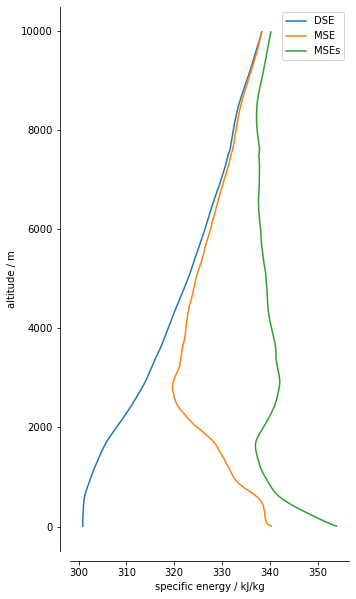

In [3]:
def add_static_energies(d):
    temperature = d['ta'] * mpunit.K
    pressure    = d['p']  * mpunit.Pa
    height      = d['alt'] * mpunit.m
    specific_humidity = d['q']
    d['DSE']  = mpcalc.dry_static_energy(height, temperature).metpy.dequantify()
    d['MSE']  = mpcalc.moist_static_energy(height, temperature, specific_humidity).metpy.dequantify()
    
    # for saturaed moist energy we assume a saturated profile
    relative_humidity  = np.ones(d['q'].shape)
    mixing_ratio       = mpcalc.mixing_ratio_from_relative_humidity(pressure, temperature, relative_humidity)
    saturated_humidity = mpcalc.specific_humidity_from_mixing_ratio(mixing_ratio)
    d['MSEs'] = mpcalc.moist_static_energy(height, temperature, saturated_humidity).metpy.dequantify()
     
    d['DSE']  = d['DSE' ].assign_attrs(standard_name='dry_static_energy',  label='DSE')
    d['MSE']  = d['MSE'].assign_attrs(standard_name='moist_static_energy', label='MSE')
    d['MSEs'] = d['MSEs'].assign_attrs(standard_name='saturated_moist_static_energy', label='MSEs')
    return d

def fig_static_energy_profiles():
    d = add_static_energies(joanne_data())
    variables = ['DSE', 'MSE', 'MSEs']
    fig, ax = fig_multivar_profile(d, variables, xlabel='specific energy / kJ/kg')
    return fig, ax

fig, ax = fig_static_energy_profiles()
fig.show()

As the latent heat is set by the relative humidity, a moist static energy profile from real world data will always lie between the dry static energy and the saturated moist static energy and the position of the moist static energy between those two edge cases reflects its relative humidity. Potential energy increases linear with height and thermal energy decreases following the air temperature profile. In our case this temperatur decrease is relatively linear (see first plot above). In the lower part of the profile, up to the inversion layer, changes in moist static energy can be contributed to changes in relative humidity.

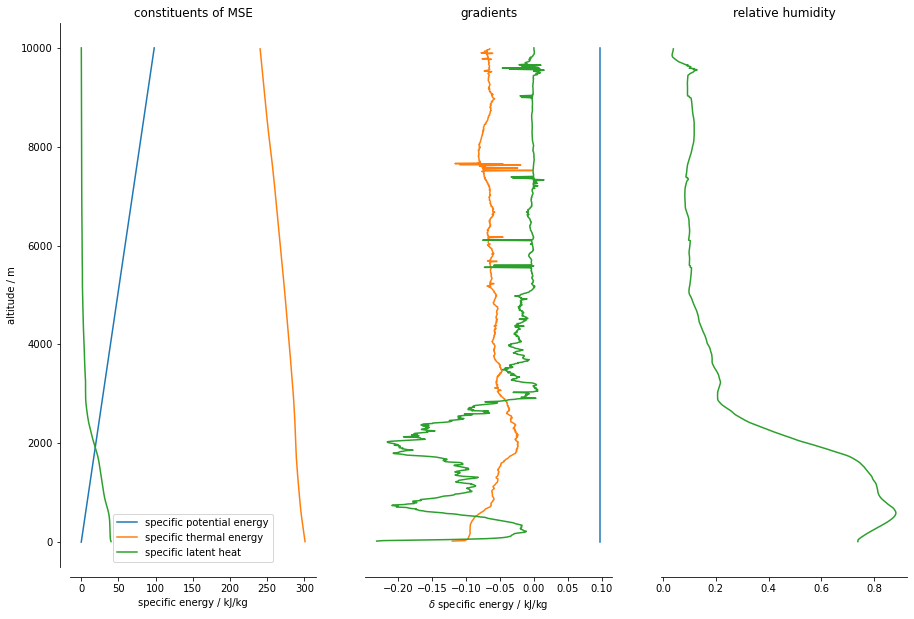

In [13]:
def relative_humidity(d):
    temperature = d['ta'] * mpunit.K
    pressure    = d['p']  * mpunit.Pa
    specific_humidity  = d['q']
    return mpcalc.relative_humidity_from_specific_humidity(pressure, temperature, specific_humidity)

def ax_relative_humidity(ax, d, varname='RH', *args, **kwargs):
    d[varname] = relative_humidity(d)
    d[varname] = d[varname].assign_attrs(standard_name='relative_humidity', label=varname)
    ax.plot(d[varname].values, d[varname].alt.values,label=d[varname].label, **kwargs)
    return  ax

def gradient(array):
    grad = np.zeros(len(array))
    for i in range(1,len(grad)): grad[i] = array[i] - array[i-1]
    grad[0] = np.nan
    return grad

def add_specific_energies(d):
    d = joanne_data()
    temperature = d['ta'] * mpunit.K
    pressure    = d['p']  * mpunit.Pa
    height      = d['alt'] * mpunit.m
    specific_humidity = d['q']
    g = mpconst.earth_gravity
    pot = g * height 
    d['specific potential energy'] = pot.metpy.dequantify()
    Cp = mpconst.Cp_d
    d['specific thermal energy'] = (Cp * temperature).metpy.dequantify()
    r = mpcalc.mixing_ratio_from_specific_humidity(specific_humidity)
    Lv = mpconst.Lv
    d['specific latent heat'] = (r * Lv ).metpy.dequantify()
    return d

def add_gradients(d, variables):
    for var in variables:
        d[var + ' gradient'] = gradient(d[var].values)
    return d

def fig_MSE_constituents(d):
    d = add_specific_energies(d)
    variables = ['specific potential energy', 'specific thermal energy', 'specific latent heat']
    d = add_gradients(d, variables)
    fig, axs = plt.subplots(1,3, figsize=(15,10), sharey=True)

    ax = axs[0]
    for var in variables:
        ax.plot(d[var].values / 1000, d[var].alt.values,label=var)
    ax.set_title('constituents of MSE')
    ax.set_xlabel('specific energy / kJ/kg')
    ax.set_ylabel('altitude / m')
    ax.legend()

    ax = axs[1]
    for var in ['specific potential energy gradient', 'specific thermal energy gradient', 'specific latent heat gradient']:
        ax.plot(d[var].values / 1000, d.alt.values,label=var)
    ax.set_xlabel("$\\delta$ specific energy / kJ/kg")
    ax.set_title('gradients')

    ax = axs[2]
    ax_relative_humidity(ax,d, color='tab:green')
    ax.set_title('relative humidity')

    for ax in axs: adjust_spines(ax, ['left', 'bottom'])
    for ax in [axs[1],axs[2]]: 
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False, labelleft=False)
    return fig, axs

fig, axs = fig_MSE_constituents(joanne_data())
fig.show()

In [31]:
j = joanne_data(); print(f'max(RH) at {j.alt.values[np.nanargmax(relative_humidity(j).values)]} m')

max(RH) at 590 m


The cloud layer in the trades wind region is set between lifting condensation level (LCL) and the inversion. Both are visible in the relative humidity profile. Relative humidity increases from the surface up to the LCL where it reaches its highest values and then decreases gradually up to the inversion at around 2900m.

<!--
2. Mesoscale vertical velocity: How are the area-averaged mass divergence D, the vertical velocity W and the pressure velocity ω related? How can you compute the latter two from the former?
3. Vertical structure:
    1. Can you identify the different layers characterizing the vertical structure of the trade-wind boundary layer? At which heights can you find the 
        1. mixed layer, 
        1. the transition layer, 
        1. the cloud layer,
        1. the inversion layer and 
        1. the free troposphere?
    2. In which variables are these layers most clearly evident? And in which not?
    3. What is the reason for the minimum in moist static energy and θe just above the inversion layer? What does the relative position of MSE between DSE and MSEs measure?
-->

## What makes a good Wikipedia article?

A wikipedia article should also not contain original work and should be written in a neutral tone. It should have the following structure:

 - **Lead section**: a clear summary of the most important parts of the article. It should touch all topics. This part is particularly important as it is displayed as a peek preview in search enginges and [navigation popups](https://en.wikipedia.org/wiki/Wikipedia:Tools/Navigation_popups). 
 - **Infobox**: Contains key information in a small table. Not a must, but useful. 
 - **Body of the article**: Each *big idea* should have its own heading. An article (in particular a new one) can have just one section. 
 - **Images**: Freely licensed images are made available via Wikimedia Commons. If you own an image you can upload it there.
 - **References**: These are created automatically from sources defined in the text body (`<ref>[http://web.link Link text], description text.</ref>`).
 
Many articles on wikipedia do not follow this guideline. The article on [Cloud Feedback](https://en.wikipedia.org/wiki/Cloud_feedback) for instance has two sections in the body: *Other effects of cloud feedback* and *Cloud feedback in IPCC report*. The section names repeat the article name (*cloud feedback*), which is considered bad style. The lead section is not purely a summary, but explains large parts of the feedback processes. The article has not Infobox or images. In some parts the language could be simplified. 